In [2]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

In [3]:
survival = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx")

print(survival.columns)


Index(['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status',
       'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV',
       'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status',
       'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local',
       'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca',
       'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced'],
      dtype='object')


In [4]:
clinical_data = survival.copy()

# Convert date columns to datetime format
clinical_data["Date of Death"] = pd.to_datetime(clinical_data["Date of Death"], format="%m/%d/%Y")
clinical_data["RT Start"] = pd.to_datetime(clinical_data["RT Start"], format="%m/%d/%Y")

# Calculate time in days
clinical_data["time"] = (clinical_data["Date of Death"] - clinical_data["RT Start"]).dt.days - clinical_data['Length FU']

# Convert event column to boolean (Death = True, Alive = False)
clinical_data["event"] = clinical_data["Status"].apply(lambda x: True if x == "Dead" else False)

# Convert to sksurv structured array format
survival_data = Surv.from_dataframe("event", "time", clinical_data)
print(survival_data )


[( True, 444.68219178) ( True, 525.47945206) (False,          nan) ...
 (False,          nan) ( True, 295.08767123) ( True, 504.47671233)]


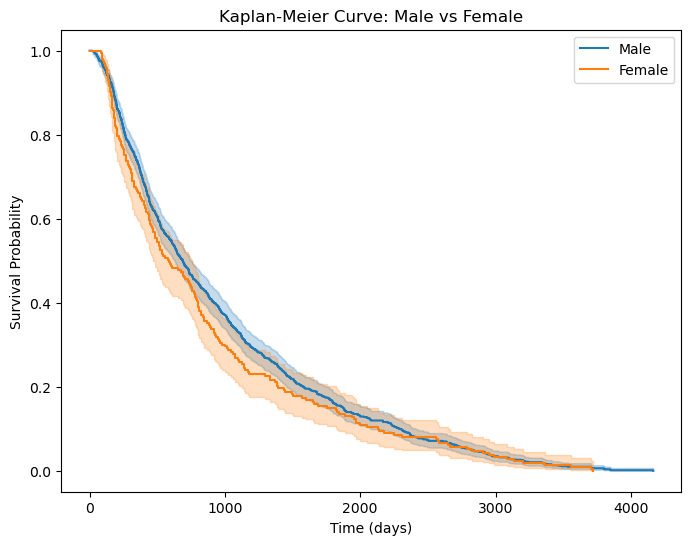

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.95 0.16      2.62


In [5]:
# Group by Sex
data1 = clinical_data.dropna(subset=["time", "event"])
group1 = data1[data1['Sex'] == 'Male']
group2 = data1[data1['Sex'] == 'Female']

# Fit Kaplan-Meier for Male
kmf1 = KaplanMeierFitter()
kmf1.fit(group1['time'], event_observed=group1['event'], label="Male")

# Fit Kaplan-Meier for Female
kmf2 = KaplanMeierFitter()
kmf2.fit(group2['time'], event_observed=group2['event'], label="Female")

# Plot Kaplan-Meier Curves
plt.figure(figsize=(8, 6))
kmf1.plot_survival_function()
kmf2.plot_survival_function()
plt.title('Kaplan-Meier Curve: Male vs Female')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


log_rank_results = logrank_test(group1['time'], group2['time'], event_observed_A=group1['event'], event_observed_B=group2['event'])
print(log_rank_results)



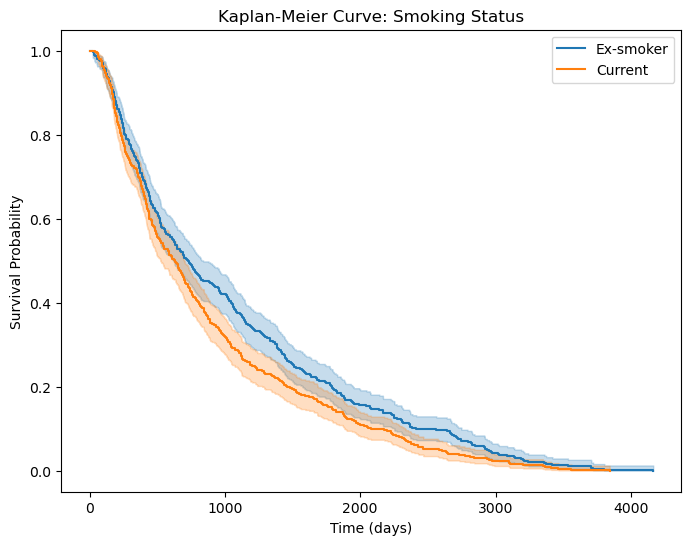

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           7.91 <0.005      7.67


In [6]:


# Group by Smoking status
data2 = clinical_data.dropna(subset=["time", "event"])
group_1 = data2[data2['Smoking Status'] == 'Ex-smoker']
group_2 = data2[data2['Smoking Status'] == 'Current']


# Fit Kaplan-Meier for Ex-smoker
kmf_1 = KaplanMeierFitter()
kmf_1.fit(group_1['time'], event_observed=group_1['event'], label="Ex-smoker")

# Fit Kaplan-Meier for Current smoker
kmf_2 = KaplanMeierFitter()
kmf_2.fit(group_2['time'], event_observed=group_2['event'], label="Current")



# Plot Kaplan-Meier Curves
plt.figure(figsize=(8, 6))
kmf_1.plot_survival_function()
kmf_2.plot_survival_function()
plt.title('Kaplan-Meier Curve: Smoking Status')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

log_rank_results = logrank_test(group_1['time'], group_2['time'], event_observed_A=group_1['event'], event_observed_B=group_2['event'])
print(log_rank_results)

<lifelines.CoxPHFitter: fitted with 1058 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1058
number of events observed = 1058
   partial log-likelihood = -6309.12
         time fit was run = 2025-03-16 20:53:46 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Age                        0.00      1.00      0.00           -0.01            0.01                0.99                1.01
Sex_Male                  -0.09      0.92      0.08           -0.24            0.07                0.79                1.07
Smoking Status_Ex-smoker  -0.19      0.83      0.07           -0.32           -0.05                0.72                0.95
Smoking Status_Non-smoker -0.08      0.92      0.09           -0.26            0.10                0.77                1.10
Smoking Status_unknown     0.24      1.28      0.30           -0.34            0.82                0.71                2.28

                           cmp to     z    p  -log2(p)
covariate                                             
Age                          0.00  0.18 0.85      0.23
Sex_Male                     0.00 -1.10 0.27      1.88
Smoking Status_Ex-smoker     0.00 -2.74 0.01      7.33
Smoking Status_Non-smoker    0.00 -0.91 0.36      1.47
Smoking Status_unknown       0.00  0.82 0.41      1.28
---
Concordance = 0.53
Partial AIC = 12628.24
log-likelihood ratio test = 10.67 on 5 df
-log2(p) of ll-ratio test = 4.10

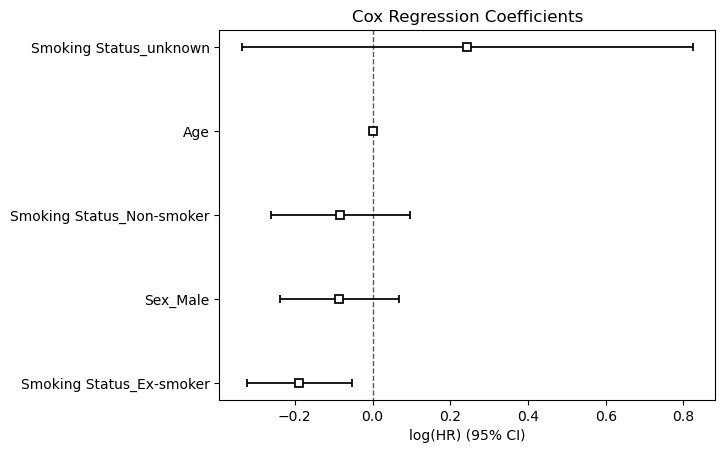

In [8]:
# choose desired covariates
data = clinical_data[["Age","Sex",'Smoking Status','time','event']].dropna()
data = pd.get_dummies(data, columns=['Sex', 'Smoking Status'], drop_first=True)

# fit the model
cph = CoxPHFitter()
cph.fit(data, duration_col='time', event_col='event')

# Print the summary of the model
cph.print_summary()

# Plot the coefficients
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()




   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5858)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5859)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1639)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1639)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9589)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9588)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9080)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9080)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1334)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1334)'>]]

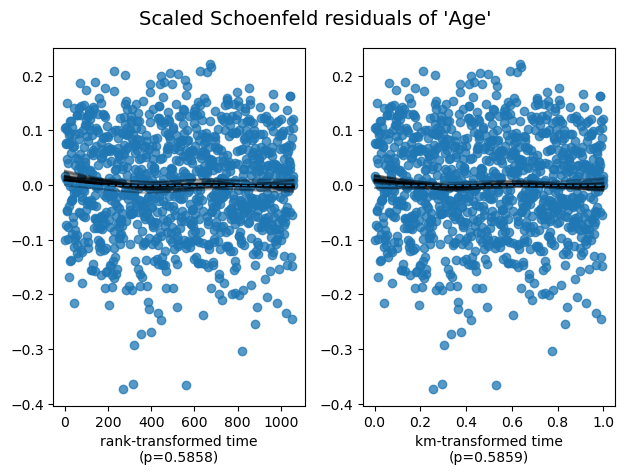

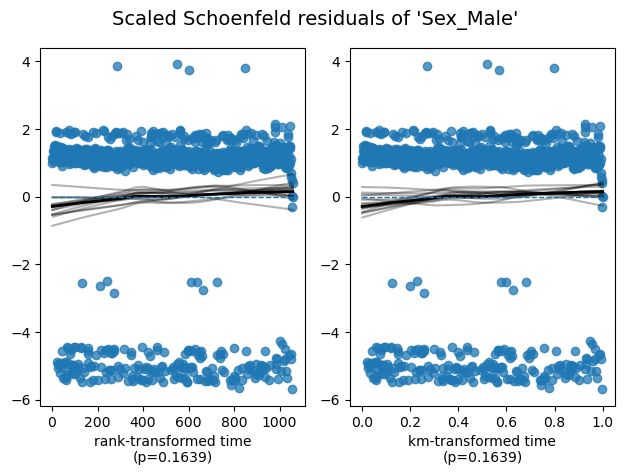

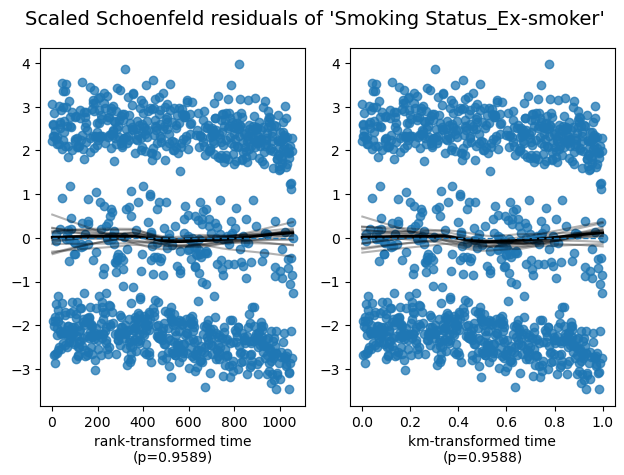

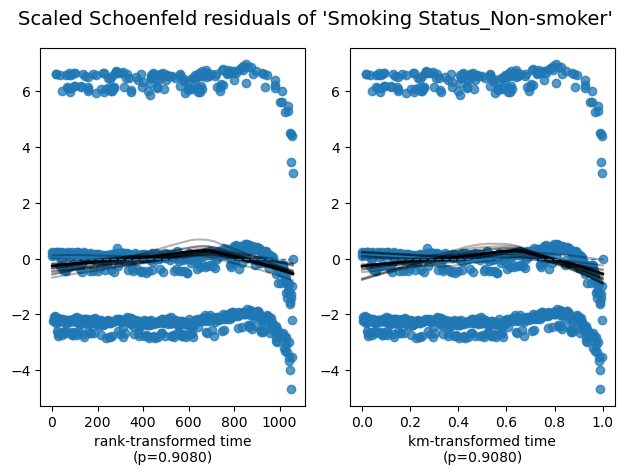

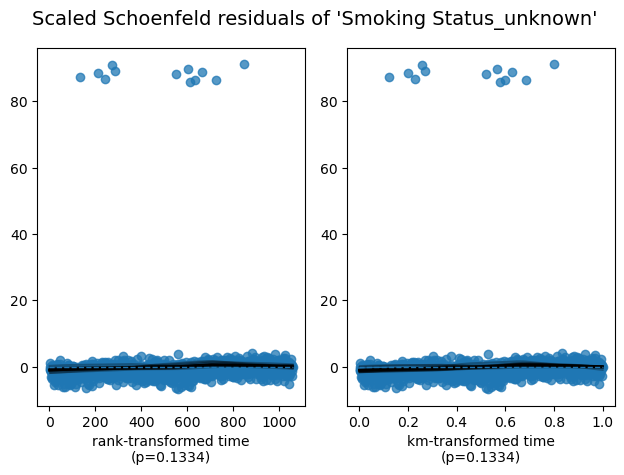

In [9]:
# check assumptions
cph.check_assumptions(data, p_value_threshold=0.05, show_plots=True)

In [10]:
# Split the data into features (X) and target (y)
# drop columns with to many missing valuse and that are redundant
X = clinical_data.drop(columns=['Last FU', 'Status','RT Start','HPV',
       'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local',
       'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca',
       'Date 2nd Ca']).dropna()
y_survival = np.array([(bool(event), time) for event, time in zip(X['event'], X['time'])], dtype=[('event', bool), ('time', float)])


# Split the data into training and testing sets
X_train, X_test, y_train_survival, y_test_survival = train_test_split(X, y_survival, test_size=0.2, random_state=42)


# Define preprocessing for numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Build and evaluate a survival model (RandomSurvivalForest)
rsf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, max_features="sqrt", n_jobs=-1, random_state=42))
])

rsf_pipeline.fit(X_train, y_train_survival)
y_pred_survival = rsf_pipeline.predict(X_test)
c_index = concordance_index_censored(y_test_survival['event'], y_test_survival['time'], y_pred_survival)
print(f'Survival Model Concordance Index: {c_index[0]}')

Survival Model Concordance Index: 0.9079376101703969


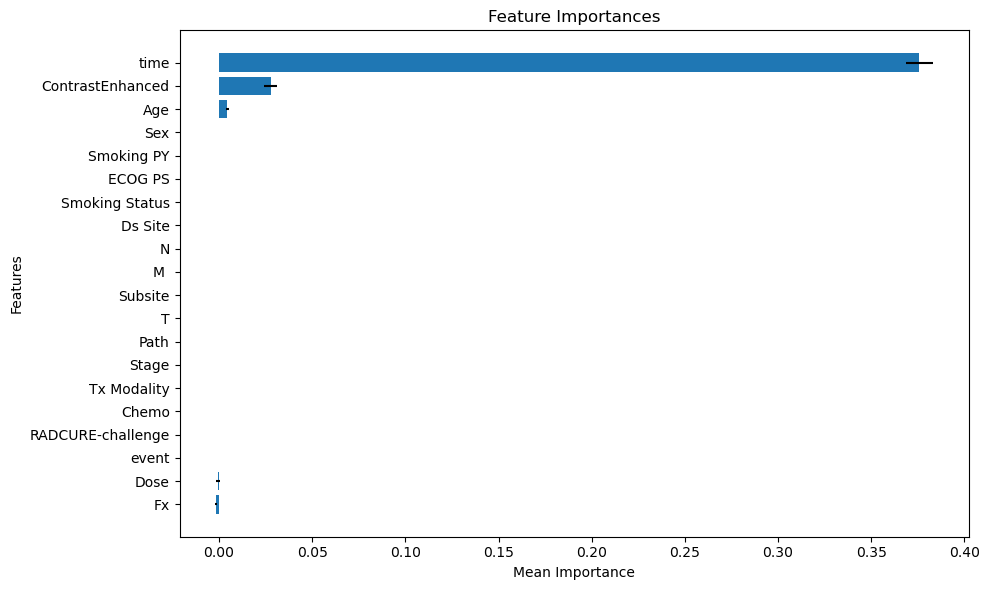

In [ ]:

new_data = clinical_data.drop(columns=['Last FU', 'Status','RT Start','HPV',
       'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local',
       'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca',
       'Date 2nd Ca']).dropna()

data_y = np.array([(bool(event), time) for event, time in zip(new_data['event'], new_data['time'])], dtype=[('event', bool), ('time', float)])

data_x= new_data.drop(columns="patient_id").astype('category')



# Define preprocessing for numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Build and evaluate a survival model (RandomSurvivalForest)
rsf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, max_features="sqrt", n_jobs=-1, random_state=42))
])
rsf_pipeline.fit(data_x, data_y)

# please refer to https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html
result = permutation_importance(rsf_pipeline, data_x, data_y, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame(
         {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=data_x.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
